In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from celmech import LaplaceLagrangeSystem
from celmech.nbody_simulation_utilities import set_timestep,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
import rebound as rb

### Set up `rebound` simulation

In [2]:
try:
    sa = rb.SimulationArchive('sa_laplace_lagrange.bin')
except RuntimeError:
    np.random.seed(1)
    sim = rb.Simulation()
    sim.add(m=1)
    m = 5e-5
    sigma_e = 0.02
    sigma_inc = sigma_e / 2
    for a in np.linspace(1,8,4):
        sim.add(
            m=m / np.sqrt(a),
            a=a,
            e=np.random.rayleigh(sigma_e),
            inc=np.random.rayleigh(sigma_inc),
            pomega = "uniform",
            Omega = "uniform",
            l="uniform"
        )
    sim.integrator = 'whfast'
    set_timestep(sim,1/40)
    sim.ri_whfast.safe_mode = 0
    sim.move_to_com()
    align_simulation(sim)
    
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    eigvals = lsys.eccentricity_eigenvalues()
    Tsec = np.max(np.abs(2 * np.pi / eigvals))
    sim.automateSimulationArchive('sa_laplace_lagrange.bin',interval=Tsec/2048,deletefile=True)
    sim.integrate(0.5*Tsec)
    sa = rb.SimulationArchive('sa_laplace_lagrange.bin')

### Set up Laplace-Lagrange secular system corresponding to the `rebound` simulation

In [3]:
nb_results = get_simarchive_integration_results(sa)
sim = sa[0]
lsys = LaplaceLagrangeSystem.from_Simulation(sim)
sec_soln = lsys.secular_solution(nb_results['time'])

## Compare $N$-body solution to the Laplac-Lagrange secular solution

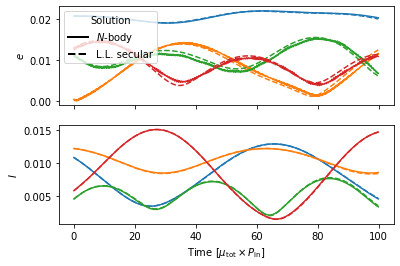

In [4]:
fig,ax = plt.subplots(2,1,sharex=True)
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
for i in range(lsys.N-1):
    l,=ax[0].plot(Time ,nb_results['e'][i])
    ax[0].plot(Time,sec_soln['e'][i],color=l.get_color(),ls='--')
    l,=ax[1].plot(Time,nb_results['inc'][i])
    ax[1].plot(Time,sec_soln['inc'][i],ls='--',color=l.get_color())   
ax[1].set_xlabel(r'Time [$\mu_\mathrm{tot} \times P_\mathrm{in} $]')
ax[0].set_ylabel('$e$')
ax[1].set_ylabel('$I$')
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k',lw=2, ls='-'),
                Line2D([0], [0], color='k',lw=2, ls='--')]
ax[0].legend(custom_lines, [r'$N$-body',"L.L. secular"],loc='upper left',title='Solution')

### Secular modes

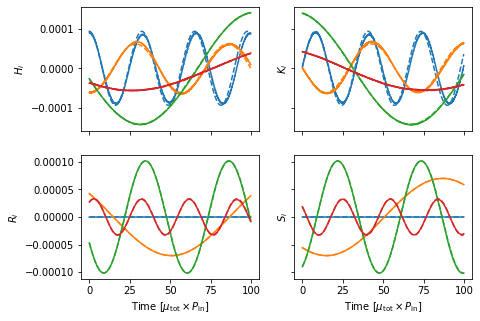

In [5]:
T,D = lsys.diagonalize_eccentricity()
nb_results['Lambda'] = np.array([p.m * np.sqrt(lsys.G * p.M) for p in lsys.particles[1:]]).reshape(-1,1) * np.sqrt(nb_results['a'])
nb_results['Gamma'] = nb_results['Lambda'] * (1 - np.sqrt(1 - nb_results['e']**2))
nb_results['eta'] = np.sqrt(2 * nb_results['Gamma'])  * np.sin(-1 * nb_results['pomega'])
nb_results['kappa'] = np.sqrt(2 * nb_results['Gamma'])  * np.cos(-1 * nb_results['pomega'])
nb_results['H'] = T.T @ nb_results['eta']
nb_results['K'] = T.T @ nb_results['kappa']
nb_results['Q'] = (nb_results['Lambda'] - nb_results['Gamma']) * (1 - np.cos(nb_results['inc']))

nb_results['sigma'] = np.sqrt(2 * nb_results['Q']) * np.cos(-1 * nb_results['Omega'])
nb_results['rho'] = np.sqrt(2 * nb_results['Q']) * np.sin(-1 * nb_results['Omega'])

U,D = lsys.diagonalize_inclination()
nb_results['R'] = U.T @ nb_results['rho']
nb_results['S'] = U.T @ nb_results['sigma']


fig,ax = plt.subplots(2,2,sharex=True,sharey='row',figsize=(7,5))
for l,pair in enumerate([('H','K'),('R','S')]):
    for m,var in enumerate(pair):
        for i in range(lsys.N-1):
            line, = ax[l,m].plot(Time,nb_results[var][i],ls='-')
            ax[l,m].plot(Time,sec_soln[var][i],ls='--',color=line.get_color())
        ax[l,m].set_ylabel(r'${}_i$'.format(var));    
ax[1,0].set_xlabel(r'Time [$\mu_\mathrm{tot} \times P_\mathrm{in} $]');
ax[1,1].set_xlabel(r'Time [$\mu_\mathrm{tot} \times P_\mathrm{in} $]');